# The Product Pricer

A model that can estimate how much something costs, from its description.


In [1]:
import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
from loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [2]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
%matplotlib inline

# The ItemLoader code

In [5]:
items = ItemLoader("Appliances").load()

Loading dataset Appliances


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:46<00:00,  2.05it/s]


Completed Appliances with 28,625 datapoints in 0.9 mins


In [6]:
print(items[1].prompt)

How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally

Price is $17.00


# Now to SCALE UP

In [7]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Musical_Instruments",
]

In [21]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Automotive


100%|██████████████████████████████████████████████████████████████████████████████| 2004/2004 [27:53<00:00,  1.20it/s]


Completed Automotive with 911,688 datapoints in 28.3 mins
Loading dataset Electronics


100%|██████████████████████████████████████████████████████████████████████████████| 1611/1611 [16:53<00:00,  1.59it/s]


Completed Electronics with 443,473 datapoints in 17.2 mins
Loading dataset Office_Products


100%|████████████████████████████████████████████████████████████████████████████████| 711/711 [04:26<00:00,  2.67it/s]


Completed Office_Products with 240,394 datapoints in 4.6 mins
Loading dataset Tools_and_Home_Improvement


100%|██████████████████████████████████████████████████████████████████████████████| 1474/1474 [18:32<00:00,  1.33it/s]


Completed Tools_and_Home_Improvement with 541,051 datapoints in 18.9 mins
Loading dataset Cell_Phones_and_Accessories


100%|██████████████████████████████████████████████████████████████████████████████| 1289/1289 [09:04<00:00,  2.37it/s]


Completed Cell_Phones_and_Accessories with 238,869 datapoints in 9.4 mins
Loading dataset Toys_and_Games


100%|████████████████████████████████████████████████████████████████████████████████| 891/891 [06:14<00:00,  2.38it/s]


Completed Toys_and_Games with 340,479 datapoints in 6.5 mins
Loading dataset Musical_Instruments


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [01:18<00:00,  2.73it/s]


Completed Musical_Instruments with 66,829 datapoints in 1.4 mins


In [22]:
print(f"A grand total of {len(items):,} items")

A grand total of 2,782,783 items


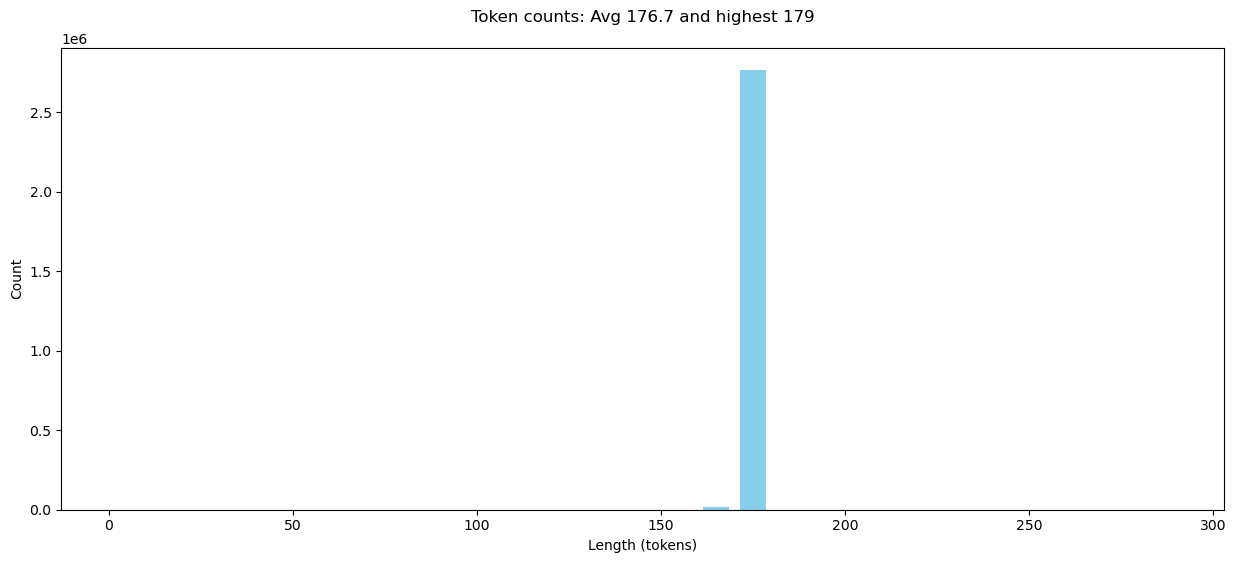

In [23]:
tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

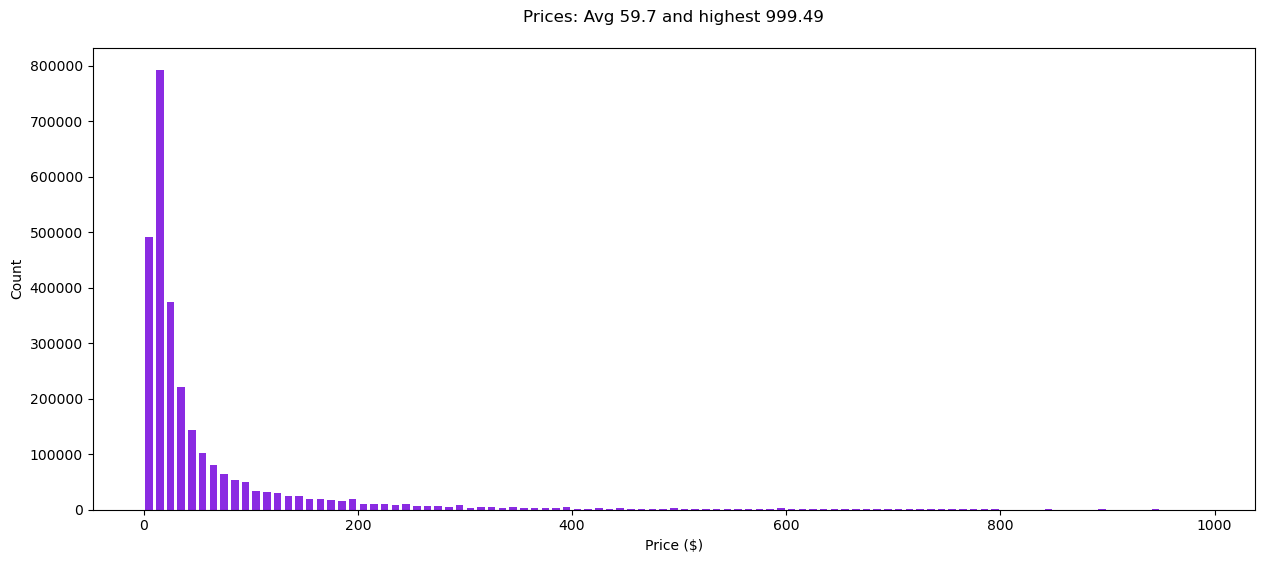

In [24]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

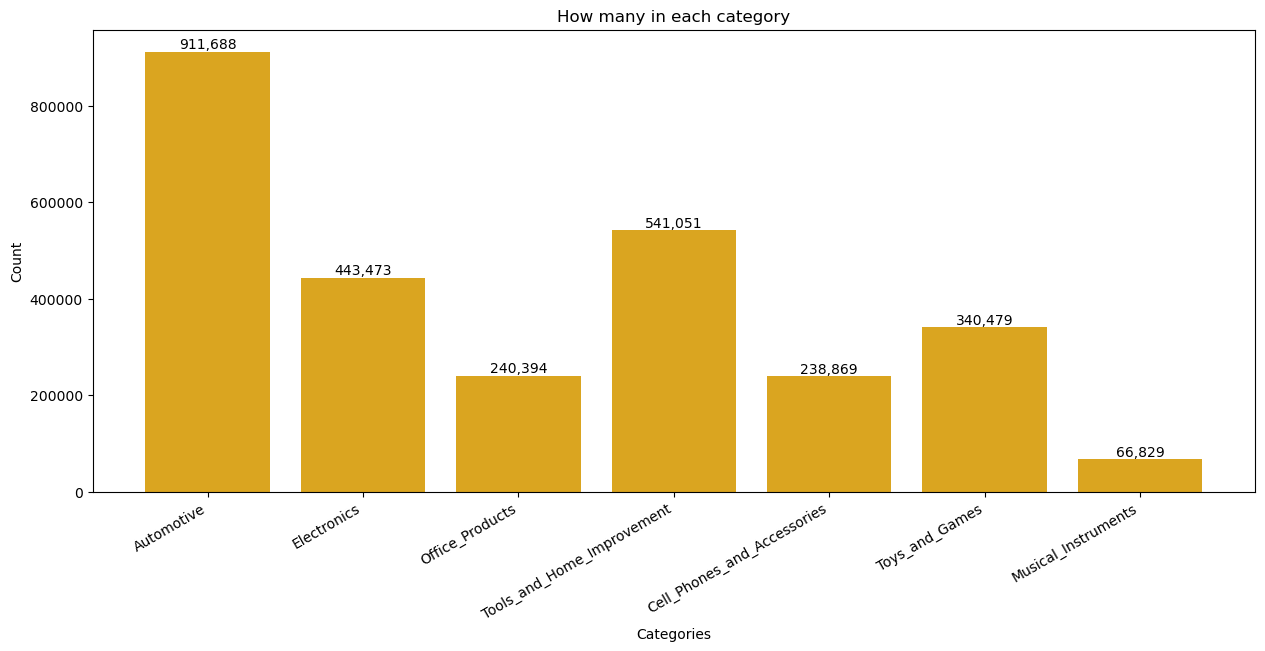

In [25]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

#print(categories)

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

# Objective

Craft a dataset which is more balanced in terms of prices. Less heavily scewed to cheap items, with an average that's higher than $60. Try to balance out the categories - fewer Automotive items.

In [26]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [27]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 406,784 items in the sample


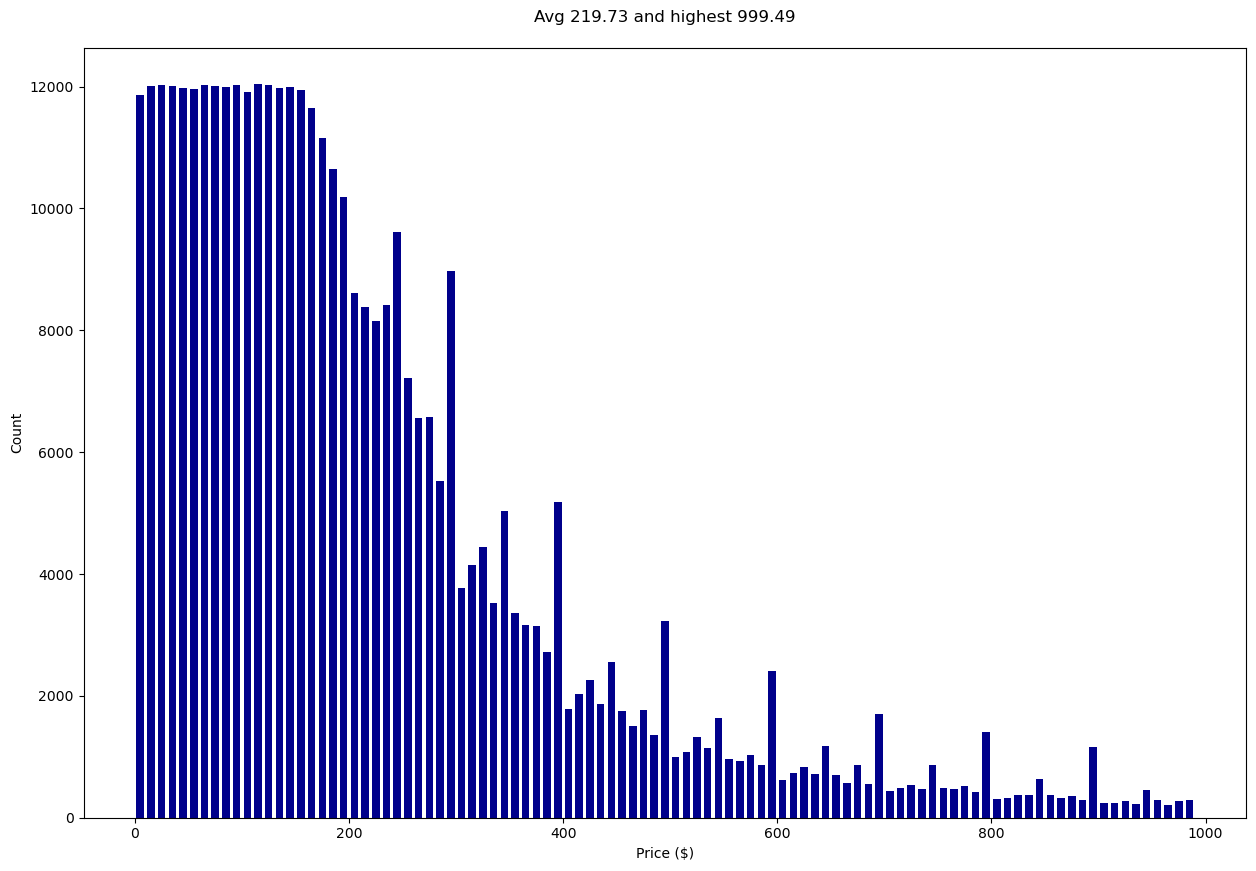

In [28]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

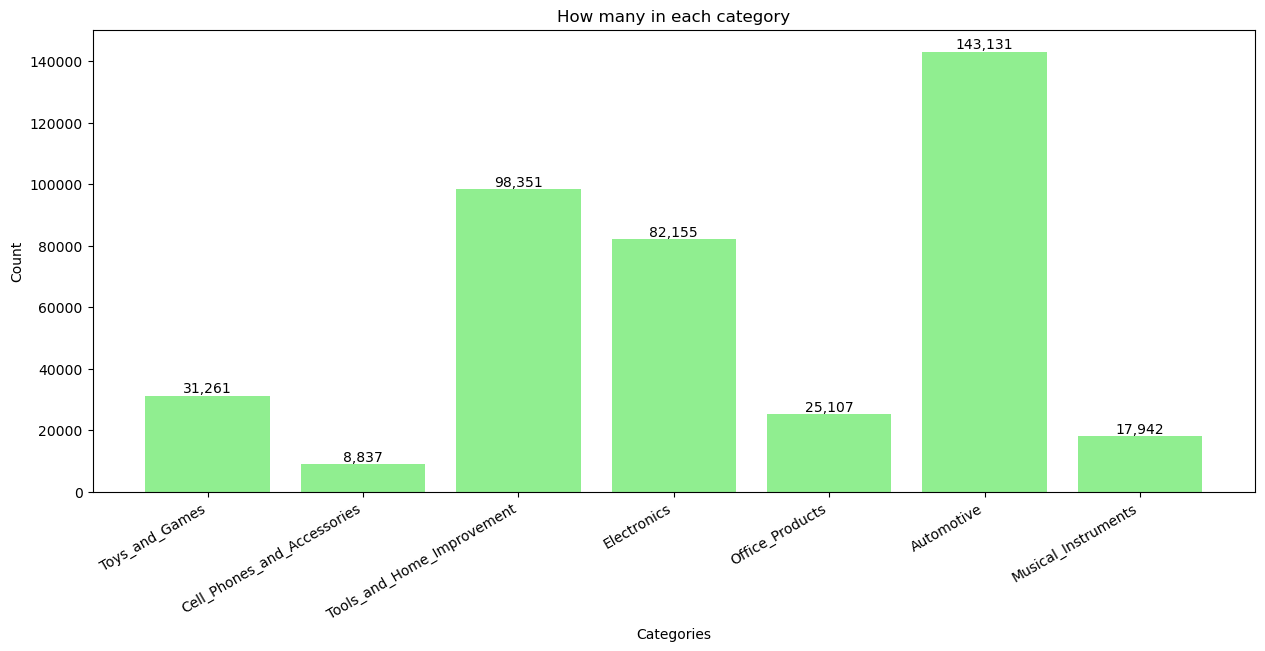

In [29]:
# OK, we did well in terms of raising the average price and having a smooth-ish population of prices
# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

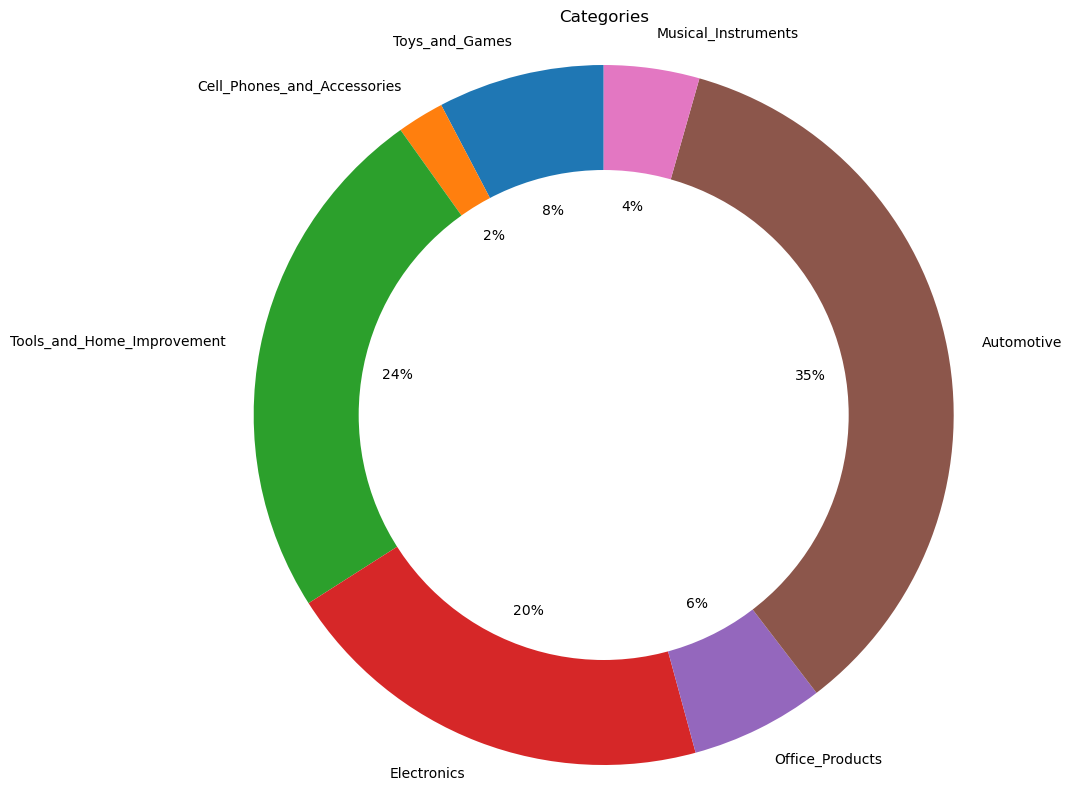

In [30]:
# Automotive still in the lead, but improved somewhat
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

# Dataset Curated!
We've crafted an excellent dataset.

Let's do some final checks

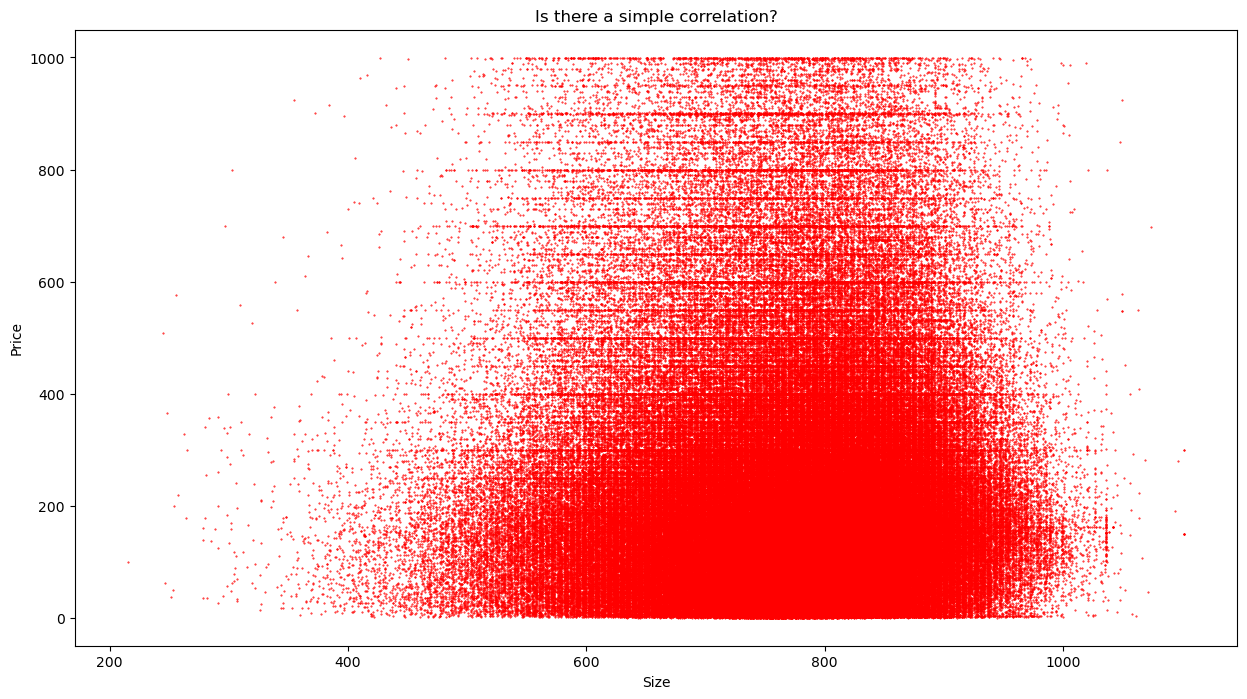

In [31]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [32]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [33]:
report(sample[398000])

How much does this cost to the nearest dollar?

Autel MaxiPRO PRO KIT 2 Years Updates + $200 Adapters, 2023 Android 11 Advanced ECU Coding Scanner, Newer Ver. of Full Bi-Directional, 30+ Services 150 Makes, FCA AutoAuth
🏅 YEARLY PROMOTION 2 YEARS UPDATES! Autel has launched a BIG promotion in thanks for all the customers' support for PRO (KIT) registered between 31st May 2023 to 31st Dec. 2023, customers enjoy 2 years free software updates to will keep your scanner always on the edge! Note please allow 5-7 days after registration, the updates will be authorized by Autel engineers manually. Or you can send the 12 digits SN of the PRO to �

Price is $799.00
[5421, 311, 30433, 271, 7117, 374, 400, 23987, 13, 410]
[' PRO', ' to', ' �', '\n\n', 'Price', ' is', ' $', '799', '.', '00']


# Observation
An interesting thing about the Llama tokenizer is that every number from 1 to 999 gets mapped to 1 token, much as we saw with gpt-4o. The same is not true of qwen2, gemma and phi3, which all map individual digits to tokens. This does turn out to be a bit useful for our project, although it's not an essential requirement.

# Finally

It's time to break down our data into a training, test and validation dataset.

It's typical to use 5%-10% of your data for testing purposes, but actually we have far more than we need at this point. We'll take 400,000 points for training, and we'll reserve 2,000 for testing, although we won't use all of them.


In [34]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 400,000 items and test set of 2,000 items


In [35]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

TMEE Handrails for Outdoor Steps Fits 1 to 3 Steps Outdoor Stair Railing，Staircase Handrail Fits with Installation Kit Transitional Handrail for Concrete Steps or Wooden Stairs
Fits 1 OR 3 Steps handrail Design --This is a suitable 2 or 3 steps outdoor stair railing, and also suitable for level surface, all kind of different stairs. Handrail length cm, support post height cm,Middle rail length DIY Stair Railing Our Hand Rails for Steps can be multi-angle adjustment maximum adjustable angle of 65 ° to suit your specific step height, not only can be used on 2 to 3 steps, but also on flat ground, and there is no need to make any modification to the railing, just adjust the middle railing so that

Price is $127.00


In [36]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

3-in-1 Pocket Hole Jig Kit, Woodworking Doweling Jig Set, Positioning Punch Tools with Positioning Clip, Adjustable Drilling Guide for Puncher Locator Carpentry Woodwork
(Specifics)This finely machined hole drilling guide kit was designed with precision scale on its main body, the scale is adjustable according to the thickness of the plank to make your woodworking much precise and convenient. (Material) The drill kit and ring are made of carbon steel, the positioner is made of Anti-Rust hence durable aluminum. (Multi-function) Multi-purpose drill guide, for drilling dowel holes and vertical holes. Complete set of combinations meet your different drilling needs under multiple circumstances. (Premium Precision) The oblique jig was processed in high precision CNC machining to ensure an exact and

Price is $


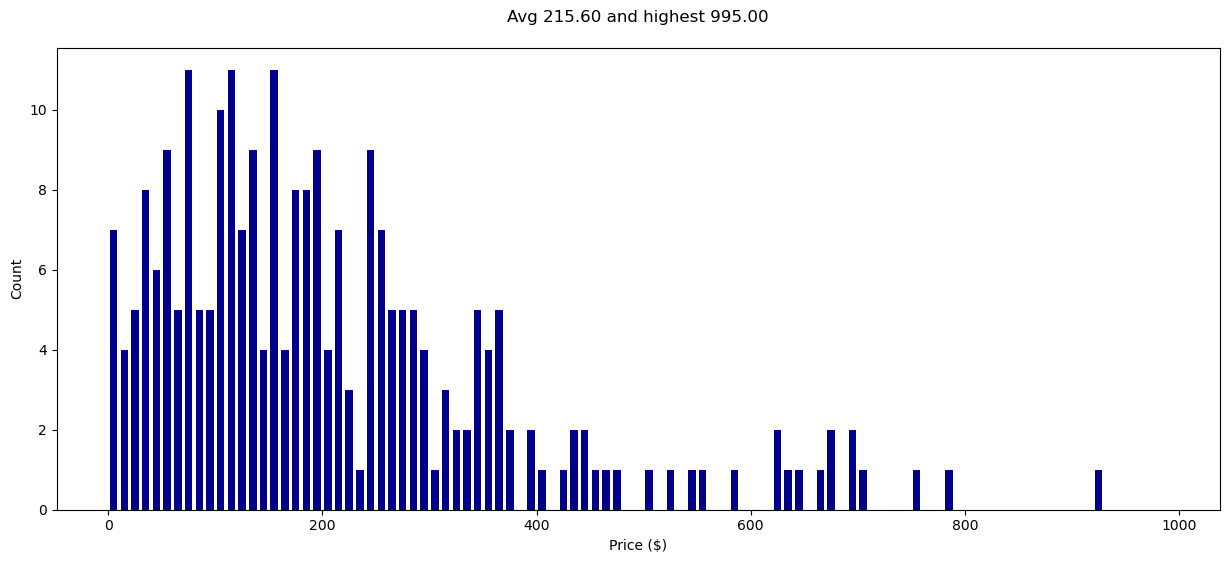

In [37]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

# Finally - upload your brand new dataset

Convert to prompts and upload to HuggingFace hub

In [38]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [39]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [40]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)